In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling, TrainingArguments, \
    Trainer
from datasets import load_dataset
import matplotlib.pyplot as plt

## References
1. https://www.youtube.com/watch?v=bGiFkOsZjKs&ab_channel=MakeStuffWithAI
2. https://huggingface.co/docs/transformers/v4.18.0/en/tasks/language_modeling

In [8]:
def plot_hist_tokens(dataset, token_or_char):
    fontsize = 14

    if token_or_char == 'token':
        plt.hist([len(x['text'].split(" ")) for x in dataset['train']])
    elif token_or_char == 'char':
        plt.hist([len(x['text']) for x in dataset['train']])
    else:
        raise Exception(f'token_or_char can only be token or char')

    plt.xlabel(f'Number of {token_or_char}', fontsize=fontsize)
    plt.ylabel("Count", fontsize=fontsize)
    plt.show()


def inference(prompt, model):
    inputs = tokenizer(prompt, return_tensors='pt')
    outputs = model.generate(inputs.input_ids,
                             pad_token_id=tokenizer.pad_token_id,
                             max_new_tokens=200,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95)
    outputs_string = tokenizer.batch_decode(outputs)

    # print(f'inputs: {inputs}')
    # print(f'outputs: {outputs}')

    return outputs_string

## Test out the base GPT2 model

In [6]:
batch_size = 32
num_train_epochs = 3

model_name = 'distilgpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

prompt = 'Once upon a time'
outputs_string = inference(prompt, model)
print(f'base GPT2 model, outputs_string: {outputs_string}')

base GPT2 model, outputs_string: ["Once upon a time, the human body was the only place a human body could reach. However, it still didn't matter to the god. Because for me, he made a big mistake. In any case, when he tried to give me something, I really couldn't get it because he was making his right mistakes.\n\nAfter my first contact with him, we realized that his name was the same from when we arrived at Kainzouya, but he was too long for us to know it at that time. So, that's what I decided to do.\nIn order to learn something more, I changed my position on Kainzouya. As I was told, Kainzouya was a demon, so I changed my status for the first time.\nSince that time, I have gained new information about my previous identity. It was only when my first contact with him made me feel like I was a demon.\nFor this reason, I am already now able to"]


In [9]:
data_size = 1000
small_stories_dataset = load_dataset('roneneldan/TinyStories', split=f'train[:{data_size}]')
small_stories_dataset = small_stories_dataset.train_test_split(train_size=0.8)
print(f'small_stories_dataset: {small_stories_dataset}')

Repo card metadata block was not found. Setting CardData to empty.


small_stories_dataset: DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 800
    })
    test: Dataset({
        features: ['text'],
        num_rows: 200
    })
})


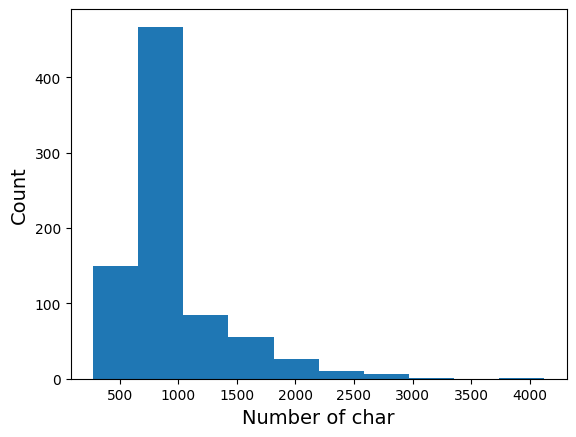

In [10]:
plot_hist_tokens(small_stories_dataset, token_or_char='char')

##  Fine-tuning GPT2 with TinyStories

In [5]:
def preprocess_batch(batch, max_length=1000):
    trimmed_text_items = [x[:max_length] for x in batch['text']]
    return tokenizer(trimmed_text_items)


tokenized_dataset = small_stories_dataset.map(preprocess_batch,
                                              batched=True,
                                              batch_size=batch_size,
                                              remove_columns=small_stories_dataset['train'].column_names,
                                              )
print(tokenized_dataset['train'][0])

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'input_ids': [7454, 2402, 257, 640, 612, 373, 257, 1310, 2576, 508, 6151, 13229, 13, 1375, 19092, 510, 530, 3329, 290, 1965, 607, 1995, 11, 366, 6090, 356, 467, 319, 257, 5296, 1909, 1701, 2332, 11254, 13541, 290, 531, 11, 366, 5297, 11, 1309, 338, 467, 2474, 220, 198, 198, 464, 1310, 2576, 1392, 12049, 2952, 290, 484, 1816, 2354, 13, 383, 4252, 373, 6016, 290, 262, 6766, 373, 257, 4950, 3124, 13, 198, 198, 464, 1995, 290, 262, 1310, 2576, 6807, 284, 262, 3952, 290, 1816, 284, 262, 16723, 13, 383, 1310, 2576, 2627, 845, 6568, 290, 2227, 284, 11240, 262, 16723, 13, 1375, 13176, 262, 4859, 290, 33091, 262, 1660, 13, 198, 198, 464, 16723, 2627, 257, 20239, 348, 1901, 7742, 286, 1257, 13, 383, 1310, 2576, 373, 523, 3772, 326, 673, 39480, 1088, 351, 8716, 13, 14384, 262, 348, 1901, 7742, 11, 673, 1043, 20239, 5916, 11, 12586, 11, 290, 617, 1402, 14068, 13, 220, 198, 198, 464, 1995, 290, 262, 1310, 2576, 550, 257, 7932, 5296, 290, 4504, 1363, 351, 6041, 286, 4950, 9846, 13], 'attention_mask

In [6]:
# Data collator creates mini training batches, and ensures the same length through padding or truncation
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                                mlm=False,
                                                )
print(f'data_collator: {data_collator}')

data_collator: DataCollatorForLanguageModeling(tokenizer=GPT2TokenizerFast(name_or_path='distilgpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}, mlm=False, mlm_probability=0.15, pad_to_multiple_of=None, tf_experimental_compile=False, return_tensors='pt')


In [7]:
training_args = TrainingArguments(output_dir='./output',
                                  evaluation_strategy='epoch',
                                  num_train_epochs=num_train_epochs,
                                  )
trainer = Trainer(model=model,
                  train_dataset=tokenized_dataset['train'],
                  eval_dataset=tokenized_dataset['test'],
                  args=training_args,
                  data_collator=data_collator,
                  )
trainer.train()

C:\Users\billt\PycharmProjects\DeepLearning\dl_venv\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,2.245770
2,No log,2.194003
3,No log,2.180306


TrainOutput(global_step=300, training_loss=2.3090610758463543, metrics={'train_runtime': 36.8966, 'train_samples_per_second': 65.047, 'train_steps_per_second': 8.131, 'total_flos': 162371433922560.0, 'train_loss': 2.3090610758463543, 'epoch': 3.0})

In [8]:
# Load model from the latest checkpoint
model = AutoModelForCausalLM.from_pretrained('./output/checkpoint-1000')
prompt = 'Once upon a time'
outputs_string = inference(prompt, model)
print(f'fine-tuned, outputs_string: {outputs_string}')

fine-tuned, outputs_string: ["Once upon a time, there was a little girl named Lily. She was only three years old but she loved to play outside with her friends. One day, she went to the park to play with her friends. She saw lots of beautiful birds, animals and animals.\n\nLily was playing in the park with her friends and felt very excited. She went to the birds and looked at them closely. They saw birds and animals and animals and looked at Lily's eyes. Lily was happy to see the birds and animals and smiled. She was so happy to be surrounded by the birds and animals she saw each time.\n\nWhen she was done playing with her friends, she felt a bit sad. She wanted to be sure she was getting more and more excited. Lily felt really bad and sad at losing her friends, because she lost her friends in her park. She looked up and saw that the birds were flying away and the animals and animals had a good time in the park.\n\nLily felt"]
